クラスタリングの前にPCAを使うと、**各主成分に相関がないため（直交しているので）ユークリッド距離で距離を定義できる**<br>
PCAをしていない場合、軸に相関があるのでマハラノビス距離を利用する

主要な潜在変数(解釈は主観的に行う必要がある)に絞れるので説明がしやすい。

### クラスタリングの終了条件
1. サンプルの所属するクラスが変わらなくなる。
2. SSEという 目的関数が許容範囲内に収まる。<br />
    SSEを考えることでサンプルのクラス遷移が収束しなくても学習を打ち切ることができる。<br />
    SSEを微分したりしてクラスを求めるわけではない。単なる指標。

### K-meansの弱点
- 超球状でないクラスタ、サンプル数の異なるクラスタの検出が難しい<br>
    SSEが二乗和なので遠いサンプルは採用しづらい→超球になりやすい
- クラスごとのSSEが等しく重みづけされている<br>
    サンプル数が多い＝クラス内誤差が大きい＝サンプル数を減らそうとする＝サンプル数がだいたい同じに均される。<br>
    他のクラスがサンプル数の多いクラスタにめり込む


- クラスタの数を何個にすればいいか不明。特に高次元の場合は可視化できない。教師なしなのでクラス何個にするかは不明。
    - エルボー法=kの値を変えながらSSEを可視化。SSEが**ガクッと**下がるkにする。<br>
    SSEがkを増やせば小さくなるのは当たり前。セントロイドが増えるので

- シルエット分析による対策<br>
**凝集度は小さい**方がいい、**乖離度は大きい**方がいいので**シルエット係数は大きい**ほど良い<br>
**シルエット係数がマイナス**になるようなときは､クラスタリングが上手く言っていないと気づけます｡<br>
なぜなら､自分のクラスタ内のサンプルよりも､隣のクラスタ内のサンプルの方が近いということなので､<br>
**周囲がごちゃごちゃしている状況の中で無理なクラスタリングが行われてしまっている**ことを示しているからです｡<br>
シルエット係数は各サンプルに対して算出されるのでデータ数分ある。<br>
見るべきはクラスタに属するサンプル数とシルエット係数がある程度大きいか。

 - 初期値依存性によってうまくいかない場合がある<br>
     - n_initの値を変える<br>
     10などを設定すると初期値の設定を10パターンで行って最もSSEの小さくなったものを採用する。<br>
     どれかでうまくいけば良い。<br>
     - k-means++<br>
     初期値が近いとうまくいかないという知見から、離れた位置に初期値を作ろうという手法

In [1]:
from sklearn.datasets import load_iris
iris=load_iris()

In [2]:
X=iris.data
y=iris.target

In [3]:
#pcaのためにデータの標準化
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X)
X_std=scaler.fit_transform(X)

In [5]:
#pcaの実行
from sklearn.decomposition import PCA
pca=PCA(n_components=4)
X_pca=pca.fit_transform(X_std)

In [6]:
X_pca[:10]

array([[-2.26454173,  0.5057039 , -0.12194335, -0.02307332],
       [-2.0864255 , -0.65540473, -0.22725083, -0.10320824],
       [-2.36795045, -0.31847731,  0.05147962, -0.02782523],
       [-2.30419716, -0.57536771,  0.09886044,  0.06631146],
       [-2.38877749,  0.6747674 ,  0.02142785,  0.03739729],
       [-2.07053681,  1.51854856,  0.03068426, -0.00439877],
       [-2.44571134,  0.07456268,  0.34219764,  0.03809657],
       [-2.23384186,  0.24761393, -0.08257446,  0.02550516],
       [-2.34195768, -1.09514636,  0.1535624 ,  0.02679383],
       [-2.18867576, -0.44862905, -0.24655952,  0.0399073 ]])

In [10]:
# k-means法を実行
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,   # クラスタの個数を指定
            init='random',  # セントロイドの初期値の決め方を決定
            n_init=10,      # 異なるセントロイドの初期値を用いての実行回数
            max_iter=300,   # ひとつのセントロイドを用いたときの最大イテレーション回数
            tol=1e-04,      # 収束と判定するための相対的な許容誤差
            random_state=0, # セントロイドの初期化に用いる乱数生成器の状態
           )

In [11]:
# 第二主成分までを使ってクラスタリング
y_km = km.fit_predict(X_pca[:, 0:2])

In [14]:
# クラスタリングの結果を出力
import matplotlib.pyplot as plt
% matplotlib inline

# クラスタリングの結果をプロットする関数
# (クラスタの数, 学習器, 学習データ)
def kmeans_plot(n_clusters, km, X):
    # クラスタの予測値を算出
    y_km = km.fit_predict(X)
    
    # クラスタごとに散布図をプロット
    # 5クラスまでプロットできる
    for i, color, marker in zip(range(n_clusters), 'rgbcm', '*x+^'):
        plt.scatter(X[y_km==i, 0],            # 横軸の値
                    X[y_km==i, 1],            # 縦軸の値
                    color=color,              # プロットの色
                    marker=marker,            # プロットの形
                    label='cluster ' + str(i) # ラベル
                   )
    
    # クラスタの中心をプロット
    plt.scatter(km.cluster_centers_[:, 0],    # 横軸の値
                km.cluster_centers_[:, 1],    # 縦軸の値
                color='y',                    # プロットの色
                marker='*',                   # プロットの形
                label='centroids',            # ラベル
                s=300,                        # プロットのサイズを大きくして見やすくする
               )
    
    plt.legend()
    plt.grid()
    plt.show()

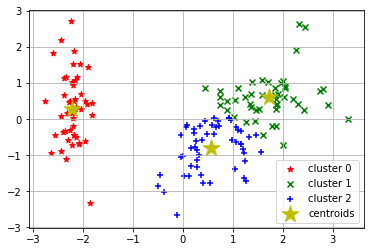

In [15]:
# プロットを実行
kmeans_plot(3, km, X_pca[:, 0:2])

教師ありのデータなので精度を出すことができる。
本来は教師なしなので自分で解釈するしかない。

In [16]:
# y_kmを確認
y_km

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       2, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2], dtype=int32)

In [18]:
# 正解ラベルを作る
# プロットを見ると､このときはversicolorとversinicaのlabelが逆になっている
# 両者のラベルを入れ替えて､正解ラベルをつくる
import numpy as np
y_correct = np.hstack((y[0:50], y[100:150]))
y_correct = np.hstack((y_correct, y[50:100]))
y_correct

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
# 正答数を累積
correct_ans = 0
for i in range(len(y_correct)):
    if y_km[i] == y_correct[i]:
        correct_ans += 1

# 正答率を出力
correct_ans / len(y)

0.8333333333333334

## K-meansが不得意な場合

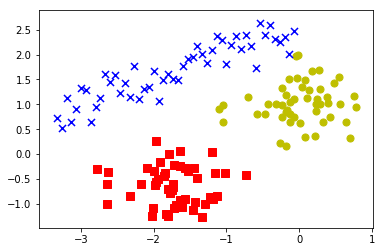

In [20]:
# 超級上でないクラスタを作成

# サンプル数50の超球状のクラスタを生成
from sklearn.datasets import make_blobs
X_1, _ = make_blobs(n_samples=50,
                 n_features=2,
                 centers=1,
                 cluster_std=0.4,
                 center_box=[0, -2],
                 random_state=6
                )

# サンプル数50の超球状のクラスタを生成
X_2, _ = make_blobs(n_samples=50,
                 n_features=2,
                 centers=1,
                 cluster_std=0.4,
                 center_box=[0, 2],
                 random_state=9
                )

# サンプル数50の細長いクラスタを生成
from numpy.random import *
seed(2)
X_31 = np.array([i/15 for i in range(-50, 0)])
X_32 = np.array([0.5*float(i) + 2 + float(randint(100))/100 for i in X_31])
X_3 = np.hstack((X_31.reshape(-1, 1), X_32.reshape(-1, 1)))

# 2種類のクラスタを色分けして表示
plt.scatter(X_1[:, 0], X_1[:, 1], c='r', marker='s', s=50)
plt.scatter(X_2[:, 0], X_2[:, 1], c='y', marker='o', s=50)
plt.scatter(X_3[:, 0], X_3[:, 1], c='b', marker='x', s=50)
plt.show()

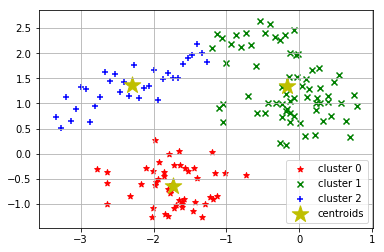

In [21]:
# 生成したクラスタのデータを統合
X = np.vstack((X_1, X_2))
X = np.vstack((X, X_3))

# k-means法を実行
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,   # クラスタの個数を指定
            init='random',  # セントロイドの初期値の決め方を決定
            n_init=10,      # 異なるセントロイドの初期値を用いた実行回数
            max_iter=300,   # ひとつのセントロイドを用いたときの最大イテレーション回数
            tol=1e-04,      # 収束と判定するための相対的な許容誤差
            random_state=0, # セントロイドの初期化に用いる乱数生成器の状態
           )

# クラスラベルを予測
y_km = km.fit_predict(X)

# プロットを実行
# 大きなクラスタのところに､小さなクラスタが食い込んでしまっているのがわかる
kmeans_plot(3, km, X)

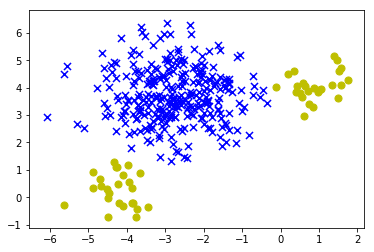

In [22]:
# サンプル数が大きく異なるクラスタを生成
from sklearn.datasets import make_blobs

# サンプル数25のクラスタを2つ生成
X_1, _ = make_blobs(n_samples=50,
                 n_features=2,
                 centers=2,
                 cluster_std=0.5,
                 random_state=3
                )

# サンプル数300のクラスタを1つ生成
X_2, _ = make_blobs(n_samples=300,
                 n_features=2,
                 centers=1,
                 cluster_std=1.0,
                 center_box=(-5, 5),
                 random_state=5
                )

# 2種類のクラスタを色分けして表示
plt.scatter(X_1[:, 0], X_1[:, 1], c='y', marker='o', s=50)
plt.scatter(X_2[:, 0], X_2[:, 1], c='b', marker='x', s=50)
plt.show()

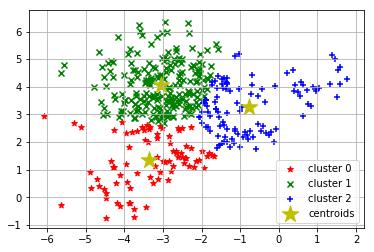

In [46]:
# 生成したクラスタのデータを統合
X = np.vstack((X_1, X_2))
X = np.vstack((X, X_3))

# k-means法を実行
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,   # クラスタの個数を指定
            init='k-means++',  # セントロイドの初期値の決め方を決定
            n_init=10,      # 異なるセントロイドの初期値を用いた実行回数
            max_iter=300,   # ひとつのセントロイドを用いたときの最大イテレーション回数
            tol=1e-04,      # 収束と判定するための相対的な許容誤差
            random_state=0, # セントロイドの初期化に用いる乱数生成器の状態
           )

# クラスラベルを予測
y_km = km.fit_predict(X)

# プロットを実行
# 大きなクラスタのところに､小さなクラスタが食い込んでしまっているのがわかる
kmeans_plot(3, km, X)

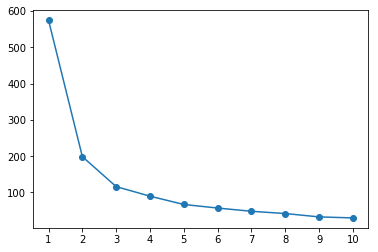

In [47]:
SSE=[]
for k in range(1,11):
    km=KMeans(
        n_clusters=k,
        init='random',
        n_init=10,
        max_iter=300,
        tol=1e-04,
        random_state=0
    )
    km.fit(X_pca[:,0:2])
    SSE.append(km.inertia_)
plt.plot(range(1,11),SSE,marker='o')
plt.xticks(range(1,11))
plt.show()

### シルエット係数による選択

In [26]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,   # クラスタの個数を指定
            init='random',  # セントロイドの初期値の決め方を決定
            n_init=10,      # 異なるセントロイドの初期値を用いた実行回数
            max_iter=300,   # ひとつのセントロイドを用いたときの最大イテレーション回数
            tol=1e-04,      # 収束と判定するための相対的な許容誤差
            random_state=0, # セントロイドの初期化に用いる乱数生成器の状態
           )

# クラスラベルを予測
y_km = km.fit_predict(X_pca[:, 0:2])

In [27]:
from sklearn.metrics import silhouette_samples

# 全サンプルのシルエット係数を計算
# (X, y_km, 利用する距離の種類)
# 'euclidiean' はユークリッド距離
s = silhouette_samples(X_pca[:, 0:2], y_km, metric='euclidean')

In [28]:
s

array([ 0.7437586 ,  0.58954614,  0.69409517,  0.64122155,  0.73369006,
        0.61141915,  0.73511038,  0.74362968,  0.50135509,  0.65881326,
        0.68571458,  0.74237058,  0.59842831,  0.56327201,  0.56628677,
        0.4531917 ,  0.62528033,  0.73935287,  0.59722791,  0.68463541,
        0.69664134,  0.70278381,  0.71659332,  0.65310985,  0.73907159,
        0.56794047,  0.72282242,  0.735419  ,  0.73779078,  0.68998794,
        0.64387074,  0.67403197,  0.59277666,  0.53806428,  0.65881326,
        0.70266667,  0.70991422,  0.65881326,  0.57082221,  0.74027388,
        0.74561258,  0.07387569,  0.66820107,  0.70668142,  0.66918434,
        0.57672248,  0.68618886,  0.68751404,  0.69636903,  0.72662061,
        0.46212585,  0.21972257,  0.48205205,  0.56842335,  0.18797752,
        0.58705332,  0.29071226,  0.4273799 ,  0.07138504,  0.61145173,
        0.43386335,  0.37349002,  0.55612643,  0.37048656,  0.5300063 ,
        0.26246967,  0.45841515,  0.61241816,  0.45906888,  0.61

In [30]:
len(s) #サンプル数と同じ

150

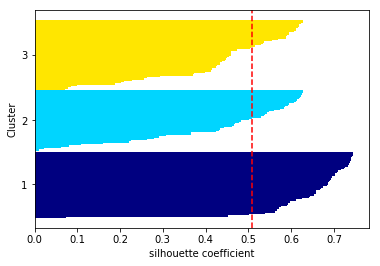

In [31]:
# シルエット図を出力
from matplotlib import cm

# シルエット図を出力する関数を定義
def draw_silhouettes(X, y_km):
    cluster_labels = np.unique(y_km)                     # クラスラベルを重複なく抽出
    n_clusters = cluster_labels.shape[0]                 # クラスタの数を算出

    # シルエット係数を計算
    # (X, y_km, 距離の種類)
    s = silhouette_samples(X, y_km, metric='euclidean')

    # 各ラベルごとにシルエット図を描画
    y_ax_lower, y_ax_upper= 0, 0                         # シルエット図の上端と下端の初期値を設定
    yticks = []                                          # 縦軸のメモリ位置を格納するリストを生成
    for i, label in enumerate(cluster_labels):
            label_s = s[y_km==label]                     # 該当するクラスタについて､シルエット係数を算出
            label_s.sort()                               # シルエット係数を小さい順に並べ替える
            y_ax_upper += len(label_s)                   # シルエット図の上端を､サンプルの数だけ引き上げる
            color = cm.jet(float(i) / n_clusters)        # color mapから色を取得
            plt.barh(range(y_ax_lower, y_ax_upper),      # 横軸の範囲を指定
                             label_s,                    # バーの幅を指定
                             height=1.0,                 # バーの厚みを指
                             color=color)                # バーの色を指定
            yticks.append((y_ax_lower + y_ax_upper) / 2) # クラスタラベルの表示位置を追加
            y_ax_lower += len(label_s)                   # シルエット図の下端を､サンプルの数だけ引き上げる

            
    plt.axvline(np.mean(s), color="red", linestyle="--") # 係数の平均値に破線を引く(横軸の値, 色, 線の形式)
    plt.yticks(yticks, cluster_labels + 1)               # クラスタレベルを表示(位置, 縦軸の値)
    plt.ylabel('Cluster')
    plt.xlabel('silhouette coefficient')
    plt.show()

# シルエット図を出力
draw_silhouettes(X_pca[:, 0:2], y_km)

In [37]:
#クラスタ数が適切でないと、クラスごとのサンプル数に偏りがあったり、マイナスの値が出現したりする。
#それを確認
from sklearn.cluster import KMeans
km=KMeans(n_clusters=2,
          init='random',
          max_iter=300,
          n_init=10,
          tol=1e-04,
          random_state=0
)

y_km=km.fit_predict(X_pca[:,0:2]) #fit_predictで予測クラスが出力

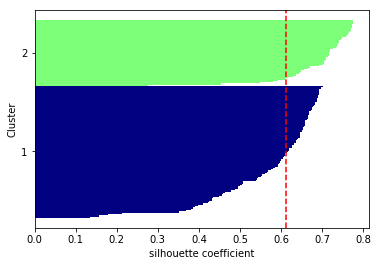

In [38]:
draw_silhouettes(X_pca[:,0:2],y_km)

In [43]:
#クラスタ数が適切でないと、クラスごとのサンプル数に偏りがあったり、マイナスの値が出現したりする。
#それを確認
from sklearn.cluster import KMeans
km=KMeans(n_clusters=4,
          init='k-means++',
          max_iter=300,
          n_init=10,
          tol=1e-04,
          random_state=0
)

y_km=km.fit_predict(X_pca[:,0:2]) #fit_predictで予測クラスが出力

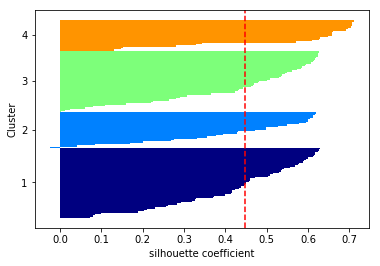

In [44]:
draw_silhouettes(X_pca[:,0:2],y_km)